## Universidad de Costa Rica
#### Facultad de Ingeniería
#### Escuela de Ciencias de la Computación e Informática


### Computabilidad y Complejidad

# Tarea Programada #2

#### Ariel Arévalo Alvarado
##### ariel.arevalo@ucr.ac.cr
#### Jorge Díaz Sagot
##### jorge.diazsagot@ucr.ac.cr

##### Ciudad Universitaria Rodrigo Facio, Costa Rica
##### II-2024

## Problema

Una organización necesita diseñar una red de comunicación robusta contra fallos como respaldo para recuperación de desastres. La construcción de esta red se modela de la siguiente forma:

Cada potencial enlace entre los nodos iniciales tiene: 
* Un costo mayor a cero
* Una calificación de fiabilidad del cero al uno

A partir de estas características, para cualquier número de nodos iniciales con potenciales enlaces, se debe construir una red donde:
* Debe existir algún camino entre cualesquiera dos nodos de la red
* Se minimice el costo total de todos los enlaces en la red
* La suma de la fiabilidad de todos los enlaces a cada nodo sea mayor o igual a uno

## Soluciones

In [8]:
import itertools
import random
import math

from src.experiment.graph import CostReliabilityGraph
from src.experiment.network import CostReliabilityNetwork

### 1. Fuerza Bruta

In [9]:
def brute_force_algorithm(topology: CostReliabilityGraph) -> CostReliabilityNetwork:
    """
    Brute force algorithm to find the optimal network.
    """
    nodes: list = topology.nodes
    all_edges: list = topology.edges
    
    best_cost = float('inf')
    best_network = None
    
    for r in range(len(nodes) - 1, len(all_edges) + 1):
        for edge_subset in itertools.combinations(all_edges, r):
            candidate = CostReliabilityNetwork()
            candidate.add_nodes(nodes)
            candidate.add_edges(edge_subset)
            if candidate.is_feasible:
                if candidate.total_cost < best_cost:
                    best_cost = candidate.total_cost
                    best_network = candidate
    return best_network

### 2. Heurística

In [10]:
def heuristic_algorithm(topology: CostReliabilityGraph) -> CostReliabilityNetwork:
    """
    Heuristic algorithm that builds a connected and reliable network
    by adding edges in order of ascending modified weight (cost/reliability),
    ensuring that each edge added helps in connectivity or node reliability.
    """
    nodes: list = topology.nodes
    all_edges: list = topology.edges

    # Step 1: Edge Preprocessing
    processed_edges = []
    for (u, v, data) in all_edges:
        cost = data["cost"]
        reliability = data["reliability"]
        modified_weight = cost / reliability
        processed_edges.append((modified_weight, u, v, data))
    processed_edges.sort()  # Sort edges by modified weight

    # Step 2: Initialization
    network = CostReliabilityNetwork()
    network.add_nodes(nodes)
    components = {node: {node} for (node, _) in nodes}  # Each node in its own component

    # Step 3: Edge Addition
    for _, u, v, data in processed_edges:
        # Get components of u and v
        comp_u = components[u]
        comp_v = components[v]

        can_add_edge = False
        if comp_u != comp_v:
            # Edge connects different components (connectivity criterion)
            can_add_edge = True
        elif (
            network.get_node_reliability(u) < 1
            or network.get_node_reliability(v) < 1
        ):
            # Edge helps nodes reach required reliability (reliability criterion)
            can_add_edge = True

        if can_add_edge:
            edge = (u, v, data)
            network.add_edge(edge)
            # If components are different, merge them
            if comp_u != comp_v:
                # Merge components
                new_component = comp_u.union(comp_v)
                for node in new_component:
                    components[node] = new_component

            # Check for termination
            if network.is_feasible:
                break

    return network


### 3. Metaheurística

In [11]:
def metaheuristic_algorithm(
    topology: CostReliabilityGraph,
    max_iterations=1000,
    initial_temperature=100,
    cooling_rate=0.95,
) -> CostReliabilityNetwork:
    """
    Metaheuristic algorithm using Simulated Annealing.
    """
    nodes: list = topology.nodes
    all_edges: list = topology.edges

    # Start with an initial solution from the heuristic algorithm
    current_network = heuristic_algorithm(topology)
    best_network = current_network
    current_cost = current_network.total_cost
    best_cost = current_cost

    T = initial_temperature
    T_min = 1e-3
    iteration = 0

    while T > T_min and iteration < max_iterations:
        # Generate a neighboring solution
        new_network = CostReliabilityNetwork()
        new_network.add_nodes(nodes)
        # Copy the edges from the current network
        new_network.add_edges(current_network.edges)

        # Randomly decide to add, remove, or replace an edge
        action = random.choice(["add", "remove", "replace"])
        if action == "add":
            # Find edges not in the network
            edges_not_in_network = [
                edge for edge in all_edges if not new_network.has_edge(edge[0], edge[1])
            ]
            if edges_not_in_network:
                edge_to_add = random.choice(edges_not_in_network)
                new_network.add_edge(edge_to_add)
        elif action == "remove":
            if len(new_network.edges) > 1:
                edge_to_remove = random.choice(new_network.edges)
                u, v, data = edge_to_remove
                new_network.remove_edge(u, v)
        elif action == "replace":
            # Remove an edge and add a new one
            if len(new_network.edges) > 0:
                edge_to_remove = random.choice(new_network.edges)
                u_remove, v_remove, data_remove = edge_to_remove
                new_network.remove_edge(u_remove, v_remove)
                # Now try to add a new edge
                edges_not_in_network = [
                    edge
                    for edge in all_edges
                    if not new_network.has_edge(edge[0], edge[1])
                ]
                if edges_not_in_network:
                    edge_to_add = random.choice(edges_not_in_network)
                    new_network.add_edge(edge_to_add)

        # Check if the new network is feasible
        if new_network.is_feasible:
            new_cost = new_network.total_cost
            delta_cost = new_cost - current_cost
            if delta_cost <= 0 or random.uniform(0, 1) < math.exp(-delta_cost / T):
                current_network = new_network
                current_cost = new_cost
                if new_cost < best_cost:
                    best_network = current_network
                    best_cost = new_cost

        # Cool down
        T *= cooling_rate
        iteration += 1

    return best_network

## Comparación

In [12]:
import perfplot

In [13]:
def setup(n):
    return CostReliabilityGraph.generate_random_solvable_graph(n)

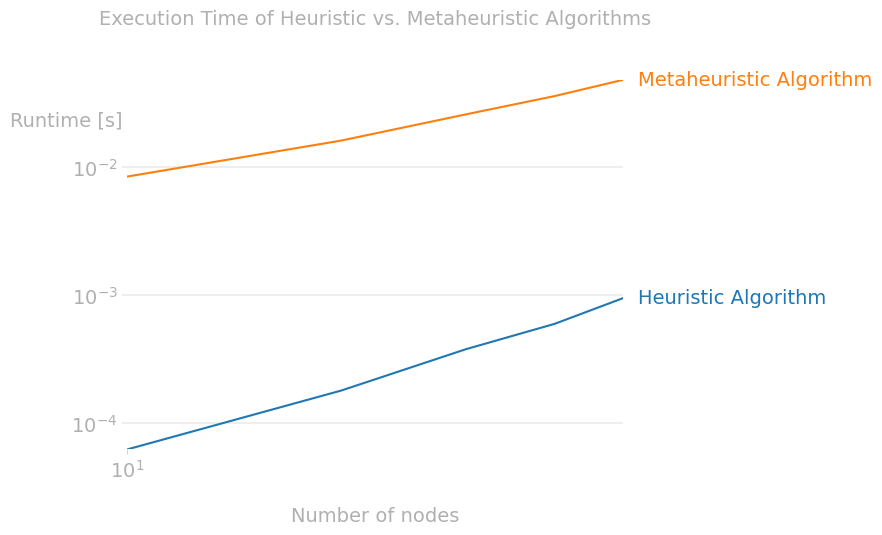

In [14]:
perfplot.show(
    setup=setup,
    kernels=[
        lambda topology: heuristic_algorithm(topology),
        lambda topology: metaheuristic_algorithm(topology),
    ],
    n_range=[10, 20, 30, 40, 50],  # Adjust as needed
    xlabel='Number of nodes',
    equality_check=None,
    labels=['Heuristic Algorithm', 'Metaheuristic Algorithm'],
    title='Execution Time of Heuristic vs. Metaheuristic Algorithms',
)

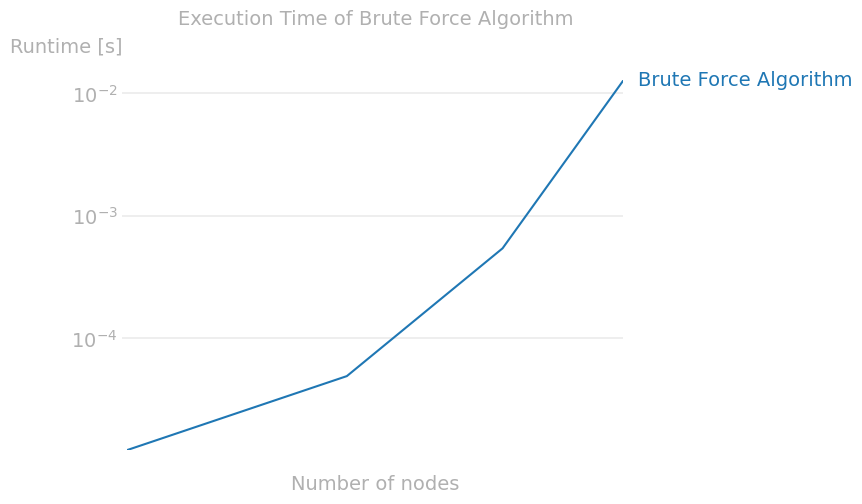

In [15]:
perfplot.show(
    setup=setup,
    kernels=[
        lambda topology: brute_force_algorithm(topology),
    ],
    n_range=[2, 3, 4, 5],  # Limit to small n
    xlabel='Number of nodes',
    equality_check=None,
    labels=['Brute Force Algorithm'],
    title='Execution Time of Brute Force Algorithm',
)


In [16]:
from memory_profiler import memory_usage

def memory_benchmark(func, G):
    mem_usage = memory_usage((func, (G,), {}), interval=0.1)
    return max(mem_usage) - min(mem_usage)


In [17]:
graph_sizes = [10, 20, 30, 40, 50, 60]
heuristic_memory = []
metaheuristic_memory = []

for n in graph_sizes:
    G = CostReliabilityGraph.generate_random_solvable_graph(n)
    mem_usage = memory_benchmark(heuristic_algorithm, G)
    heuristic_memory.append(mem_usage)
    mem_usage = memory_benchmark(metaheuristic_algorithm, G)
    metaheuristic_memory.append(mem_usage)


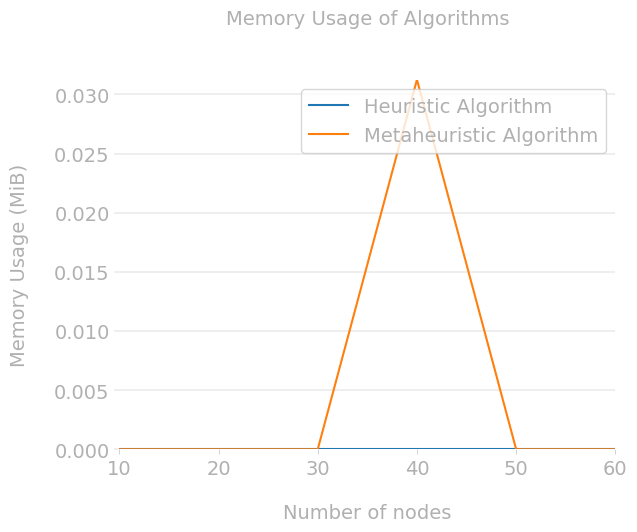

In [18]:
import matplotlib.pyplot as plt

plt.plot(graph_sizes, heuristic_memory, label='Heuristic Algorithm')
plt.plot(graph_sizes, metaheuristic_memory, label='Metaheuristic Algorithm')
plt.xlabel('Number of nodes')
plt.ylabel('Memory Usage (MiB)')
plt.title('Memory Usage of Algorithms')
plt.legend()
plt.show()
